# Game market analysis

## Введение

I have game sales data, user and expert ratings, genres and platforms. It is necessary to identify the patterns that determine the success of the game and plan the company for 2017. Pre-processing will be carried out, sales by platform will be analyzed, the impact of reviews from critics and users on sales will be assessed, a portrait of users in each region (NA, EU, JP) will be compiled, Action and Sports genre ratings are different.

## Loading the necessary libraries and getting to know the data

At this stage, we will prepare the libraries necessary for the work and the dataframe used.

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats as st
import math as mt
import datetime as dt 
import matplotlib.pyplot as plt
from functools import reduce
idx = pd.IndexSlice

#required libraries loaded

In [40]:
font = {'family': 'sans-serif',
        'color':  '#a72693',
        'weight': 'normal',
        'size': 20,
        }

In [41]:
games = pd.read_csv('/datasets/games.csv', sep = ',') 
games.info() #dataset loaded and researched

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Critical reviews are missing for 8,000 games, and user reviews are missing for 6,000 games. The rating is not available for almost 7 thousand games. Let's see what we can do with it.

In [42]:
games.sample(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
975,Forza Motorsport 6,XOne,"2,015.00",Racing,0.73,0.90,0.03,0.14,87.00,7.9,E
7718,Tom Clancy's Splinter Cell: Essentials,PSP,"2,006.00",Shooter,0.17,0.01,0.00,0.02,58.00,7.5,M
4685,Terraria,PS3,"2,013.00",Action,0.07,0.20,0.09,0.05,81.00,7.9,T
14578,Boot Camp Academy,Wii,"2,010.00",Action,0.03,0.00,0.00,0.00,nan,tbd,E10+
10936,Scooby-Doo! Who's Watching Who?,DS,"2,006.00",Adventure,0.08,0.01,0.00,0.01,nan,NaN,NaN
1720,Ty the Tasmanian Tiger,PS2,"2,002.00",Platform,0.57,0.45,0.00,0.15,70.00,8.8,E
252,Zelda II: The Adventure of Link,NES,"1,987.00",Adventure,2.19,0.50,1.61,0.08,nan,NaN,NaN
6278,Dead Rising 2: Off the Record,X360,"2,011.00",Action,0.17,0.08,0.00,0.02,72.00,7.5,M
6260,M&M's Blast!,GBA,"2,001.00",Puzzle,0.20,0.07,0.00,0.00,nan,NaN,NaN
2977,Mortal Kombat Mythologies: Sub-Zero,PS,"1,997.00",Fighting,0.38,0.26,0.00,0.04,nan,NaN,NaN


### Conclusion

Immediately discovered a large number of missing values ​​with information about the ratings of critics, users and age rating. The release year is not in a valid format.

## Data preparation

The lower case is set in the naming of the columns, the name of the column "Rating" is replaced by "ersb". The values ​​of the column with the year the games were released are given as integers.

In [43]:
games.columns=['name','platform','year_of_release','genre','na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'esrb']


games.dropna(subset=['year_of_release'], inplace=True)
games['year_of_release'] = games['year_of_release'].astype(int)
games.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb
5439,World of Final Fantasy,PS4,2016,Role-Playing,0.08,0.14,0.08,0.04,77.00,8.3,E10+
2123,Disney Tangled,DS,2010,Action,0.53,0.35,0.00,0.09,nan,NaN,NaN
13109,The Typing of the Dead,DC,2000,Shooter,0.00,0.00,0.05,0.00,83.00,7.8,M
4044,Kane & Lynch 2: Dog Days,X360,2010,Shooter,0.20,0.22,0.01,0.05,nan,NaN,NaN
2198,WWE SmackDown vs. Raw 2009,PS3,2008,Fighting,0.51,0.30,0.01,0.12,78.00,7,T
83,Pokemon Black 2/Pokemon White 2,DS,2012,Role-Playing,2.79,1.72,3.14,0.41,nan,NaN,NaN
4467,Nicktoons: Attack of the Toybots,Wii,2007,Platform,0.40,0.00,0.00,0.03,60.00,6,E
6221,Puyo Puyo! 15th Anniversary,DS,2006,Puzzle,0.00,0.00,0.28,0.00,nan,NaN,NaN
8612,NBA 2K12,PC,2011,Sports,0.09,0.05,0.00,0.02,86.00,7.1,E
4927,Condemned 2: Bloodshot,PS3,2008,Action,0.17,0.16,0.00,0.06,82.00,8.1,M


Let's replace the "tbd" values ​​in the user reviews column with nan.

In [44]:
#games['user_score'].unique()
# games.loc[games['user_score'] == 'tbd','user_score'] = np.nan
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
esrb               9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [45]:
games['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

And let's bring them to the float format.

In [46]:
games['user_score'] = games['user_score'].astype('float')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16446 non-null object
year_of_release    16446 non-null int64
genre              16444 non-null object
na_sales           16446 non-null float64
eu_sales           16446 non-null float64
jp_sales           16446 non-null float64
other_sales        16446 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
esrb               9768 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


A column is created with the cumulative amount of sales in millions.

In [47]:
games['sum_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales'] 

I lowercase the values ​​of the columns with the name and genre of the game, as well as with the name of the platform.

In [48]:
games['name'] = games['name'].str.lower()
games['platform'] = games['platform'].str.lower()
games['genre'] = games['genre'].str.lower()
games.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb,sum_sales
5196,kirby's dream land 3,snes,1997,platform,0.00,0.00,0.36,0.00,nan,nan,NaN,0.36
13092,the bureau: xcom declassified,pc,2013,shooter,0.00,0.05,0.00,0.00,66.00,6.50,M,0.05
5613,fortress,gba,2001,action,0.23,0.08,0.00,0.01,64.00,nan,E,0.32
11259,wing commander iv: the price of freedom,ps,1997,simulation,0.05,0.03,0.00,0.01,nan,nan,NaN,0.09
9713,the king of fighters '98 ultimate match,ps2,2008,fighting,0.04,0.03,0.03,0.01,nan,nan,NaN,0.11
8038,csi: fatal conspiracy,ps3,2010,adventure,0.11,0.05,0.00,0.02,39.00,5.60,M,0.18
11482,pop'n music,wii,2009,misc,0.07,0.00,0.00,0.01,nan,nan,E,0.08
12808,kimikiss (ebkore+),ps2,2008,adventure,0.00,0.00,0.06,0.00,nan,nan,NaN,0.06
8954,tamagotchi collection,ds,2011,misc,0.00,0.00,0.15,0.00,nan,nan,NaN,0.15
12660,imagine: resort owner,ds,2010,strategy,0.05,0.00,0.00,0.00,nan,nan,E,0.05


In [49]:
games.duplicated().sum() #check for duplicates

0

Checking for the number of unknown values by columns.

In [50]:
#games.isnull().sum().sort_values(ascending = False) / games.shape[0] * 100
games.isnull().mean() * 100

name               0.01
platform           0.00
year_of_release    0.00
genre              0.01
na_sales           0.00
eu_sales           0.00
jp_sales           0.00
other_sales        0.00
critic_score      51.46
user_score        54.62
esrb              40.61
sum_sales          0.00
dtype: float64

The missing values are mainly related to information about the various ratings. The lack of ratings from users and critics is probably due to the mechanism of obtaining these data from various sources. Many values with ESRB scores are omitted due to the fact that the ESRB itself was only founded in 1994.

Filling unknown values in the columns name, genre, esrb with values with a string notification of the absence of data, since even in the absence of this data, it will be possible to judge the rest of the indicators.

In [51]:
games['esrb'] = games['esrb'].fillna('unknown')
games['genre'] = games['genre'].fillna('no genre')
games['name'] = games['name'].fillna('noname')

games.loc[games['esrb'] == 'K-A', 'esrb'] = 'E' #также заменим устаревшее значение K-A рейтинга ESRB на сходное новое E
games['esrb'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

In [52]:
games.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb,sum_sales
7447,de blob 2,ps3,2011,platform,0.11,0.07,0.00,0.03,74.00,7.10,E10+,0.21
11594,far cry vengeance,wii,2006,shooter,0.06,0.01,0.00,0.01,38.00,5.30,M,0.08
6156,mission: impossible - operation surma,ps2,2003,platform,0.14,0.11,0.00,0.04,64.00,7.80,T,0.29
9737,break 'em all,ds,2005,puzzle,0.11,0.00,0.00,0.01,68.00,nan,E,0.12
15004,room zoom: race for impact,xb,2004,racing,0.02,0.01,0.00,0.00,nan,nan,unknown,0.03
14027,steambot chronicles,ps2,2005,role-playing,0.02,0.01,0.00,0.00,74.00,8.20,T,0.03
7650,zone of the enders hd collection,x360,2012,simulation,0.14,0.03,0.01,0.02,75.00,8.80,M,0.20
5757,gold's gym: cardio workout (others sales),wii,2008,sports,0.00,0.29,0.00,0.02,nan,nan,unknown,0.31
11792,famicom mini: hikari shinwa: palutena no kagami,gba,2004,platform,0.00,0.00,0.07,0.00,nan,nan,unknown,0.07
7061,final fantasy xi: treasures of aht urhgan,ps2,2006,role-playing,0.06,0.05,0.10,0.02,87.00,7.10,T,0.23


### Conclusion

All possible data and column names are reduced to lower case. Release year column corrected. Introduced a column for the amount of sales. Numerical data formats have been corrected. Lost values are standardized and given their name in the genre, age limit, and game name columns. Some outdated values of the column with age ratings have been corrected for the corresponding modern ones.

## Exploratory data analysis

Automated function for creating graphs.

In [53]:
def create_any_bar(dfr, graph_title, groupby_column, func, y='name'):
    plt.style.use('seaborn-pastel')
    plt.title(graph_title)
    df_to_plot = dfr.groupby(groupby_column)[y]
    if func == 'count':
        df_to_plot_calculated = df_to_plot.count()
        figsize = (15,5)
        plot = df_to_plot_calculated.plot(kind='bar', y=y, figsize=figsize, ec='black')
    elif func == 'sum':
        df_to_plot_calculated = df_to_plot.sum().sort_values()
        figsize = (15,10)
        plot = df_to_plot_calculated.plot(kind='barh', y=y, figsize=figsize, ec='black')

### Game releases by year

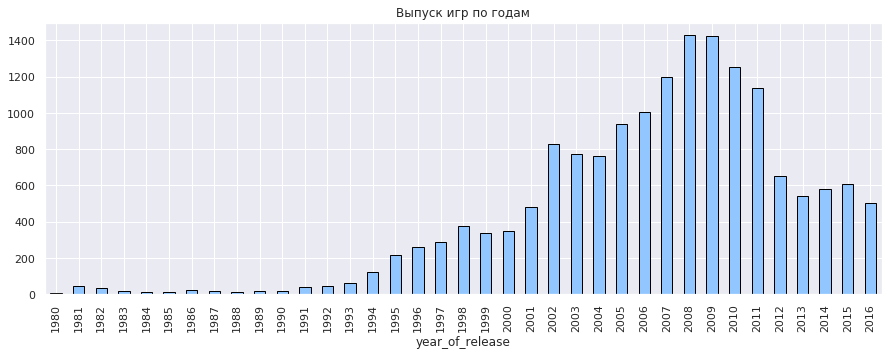

In [54]:
create_any_bar(games,'Выпуск игр по годам', 'year_of_release', 'count')

The first stage can be periodized from 1980 to 1993. During this period, the gaming industry was forming, the release of games was at a consistently low level. From 1993 to 1998, there was a steady growth, followed by a slight decline and a sharp exit from the crisis in 2002. The cycle repeated itself and until 2004 there was a slight decline in productivity and an increase in the peak value by 2008-2008. With the rise in popularity of mobile apps, the release of games on platforms plummeted and stagnated by 2013.

### Sales by platform

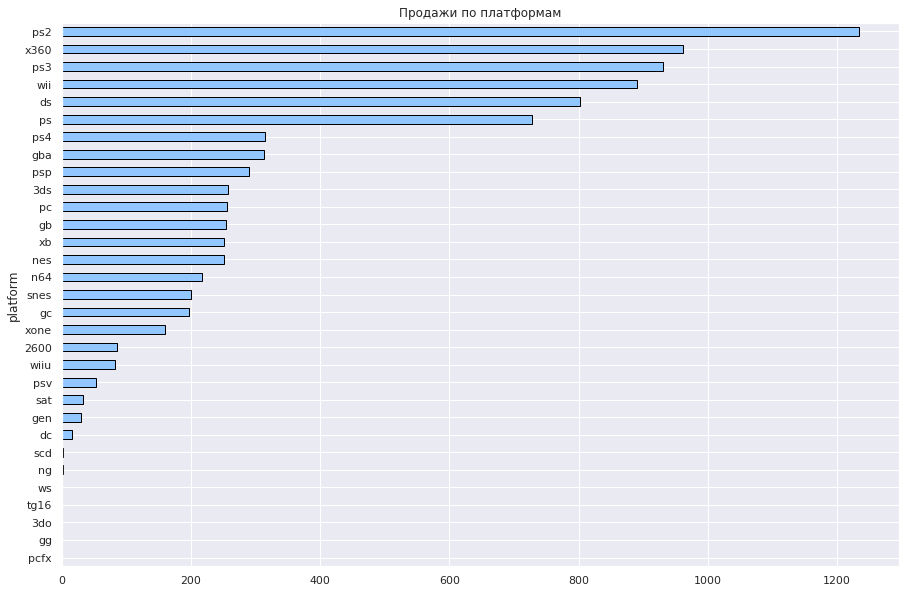

In [55]:
create_any_bar(games, 'Продажи по платформам', 'platform', 'sum', 'sum_sales')

PS2 games have been the most successful in the market, leading by a wide margin. They are followed by direct competitor Xbox360. In third place is a more modern model of the favorite - PS3, probably lower figures due to the fact that the PS2 had much more time to gain sales.

#### PS2

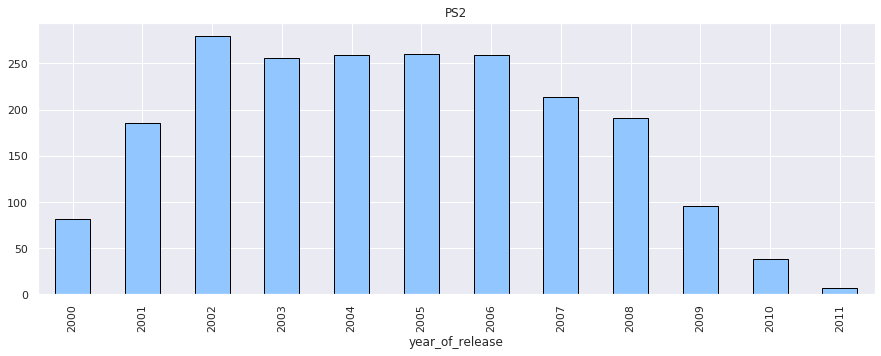

In [56]:
ps2 = games.loc[games['platform'] == 'ps2']
create_any_bar(ps2, 'PS2', 'year_of_release', 'count', 'sum_sales')

From the release date in 2000, growth in sales until 2002, consistently high sales in a five-year span (until 2006) and a gradual decline until 2011.

#### x360

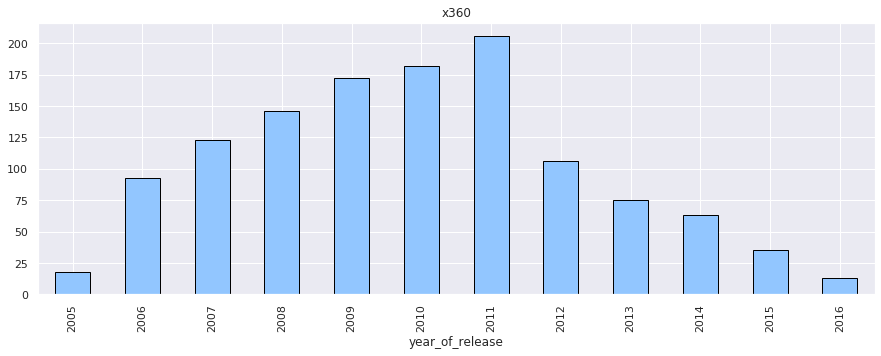

In [57]:
x360 = games.loc[games['platform'] == 'x360']
create_any_bar(x360, 'x360', 'year_of_release', 'count', 'sum_sales')

The launch of the platform in 2005 and a sharp increase in growth by 2006, followed by a period of steady five-year growth until 2011. In 2012, sales fell and declined until 2016.

#### PS3

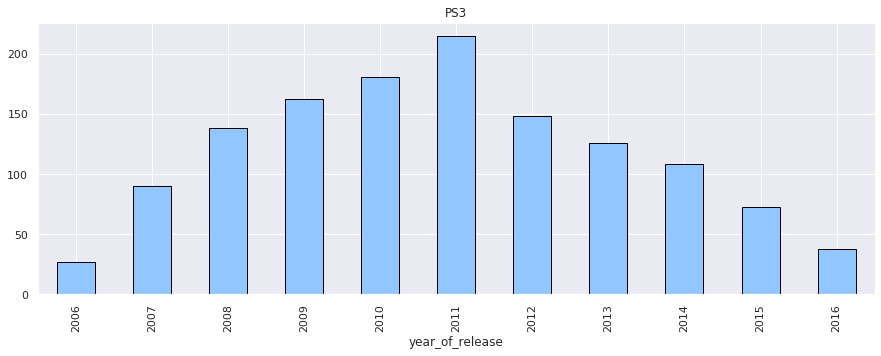

In [58]:
ps3 = games.loc[games['platform'] == 'ps3']
create_any_bar(ps3, 'PS3', 'year_of_release', 'count', 'sum_sales')

It can be seen that in 2006 the console was released, from 2007 to the peak value in 2011, there has been a steady growth for 5 years. From 2012 to 2016, there has been a steady decline.

#### Wii

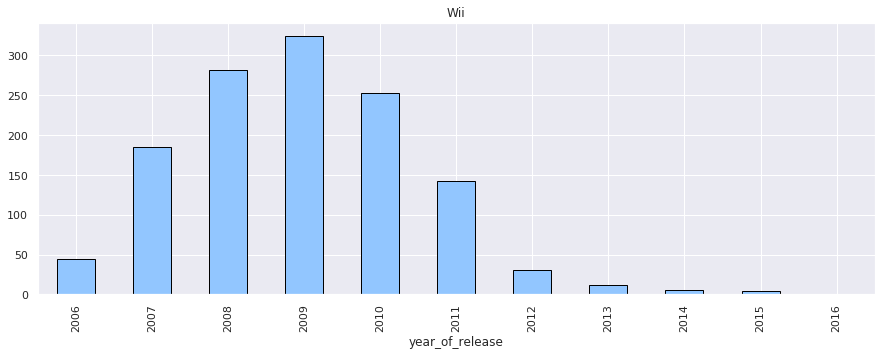

In [59]:
wii = games.loc[games['platform'] == 'wii']
create_any_bar(wii, 'Wii', 'year_of_release', 'count', 'sum_sales')

The release of the console is fixed in 2006. For this console, the five-year period spans the entire cycle of up and down sales, with a peak in 2009. From 2012 to 2016, sales of this console occupy an absolutely insignificant market share.

#### DS

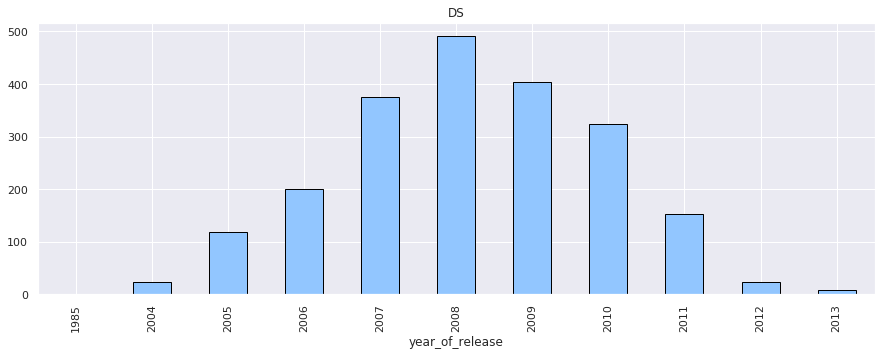

In [60]:
ds = games.loc[games['platform'] == 'ds']
create_any_bar(ds, 'DS', 'year_of_release', 'count', 'sum_sales')

By the time the sales started in 2004, the promotional campaign was not successful, but in the period from 2004 to 2008, significant growth cannot be denied, as well as a five-year decline from 2008 to 2012, after which the values are kept at an absolutely insignificant level.

In [61]:
pivot2 = games.groupby('platform').nunique().mean()
pivot2['year_of_release']

7.67741935483871

In general, the cycle of appearance and disappearance of the new console is concluded in the interval of about 10 years.

### Actual period

I propose to consider the current period as a five-year period. As can be seen from the data for this time for top platforms, depending on the success of sales during this time, both the entire cycle of growth and decline in sales, and the period of growth of this cycle can go through. For the best-selling platform, PS2, the five-year period was only a period of holding the maximum level of sales. Thus, using this time frame, you can be sure that a new game will be on sale during a period that affects the peak popularity of the console, or overlaps with its growth period.

In [62]:
df = games.loc[games['year_of_release'] >= 2012] #we take into account in the work only games that have been sold for the last five years from 2012 to 2016

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2886 entries, 16 to 16714
Data columns (total 12 columns):
name               2886 non-null object
platform           2886 non-null object
year_of_release    2886 non-null int64
genre              2886 non-null object
na_sales           2886 non-null float64
eu_sales           2886 non-null float64
jp_sales           2886 non-null float64
other_sales        2886 non-null float64
critic_score       1312 non-null float64
user_score         1531 non-null float64
esrb               2886 non-null object
sum_sales          2886 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 293.1+ KB


In [64]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,esrb,sum_sales
16,grand theft auto v,ps3,2013,action,7.02,9.09,0.98,3.96,97.00,8.20,M,21.05
23,grand theft auto v,x360,2013,action,9.66,5.14,0.06,1.41,97.00,8.10,M,16.27
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,nan,nan,unknown,14.63
33,pokemon x/pokemon y,3ds,2013,role-playing,5.28,4.19,4.35,0.78,nan,nan,unknown,14.60
34,call of duty: black ops ii,ps3,2012,shooter,4.99,5.73,0.65,2.42,83.00,5.30,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,strawberry nauts,psv,2016,adventure,0.00,0.00,0.01,0.00,nan,nan,unknown,0.01
16707,aiyoku no eustia,psv,2014,misc,0.00,0.00,0.01,0.00,nan,nan,unknown,0.01
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,nan,nan,unknown,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,nan,nan,unknown,0.01


### Potentially profitable platforms

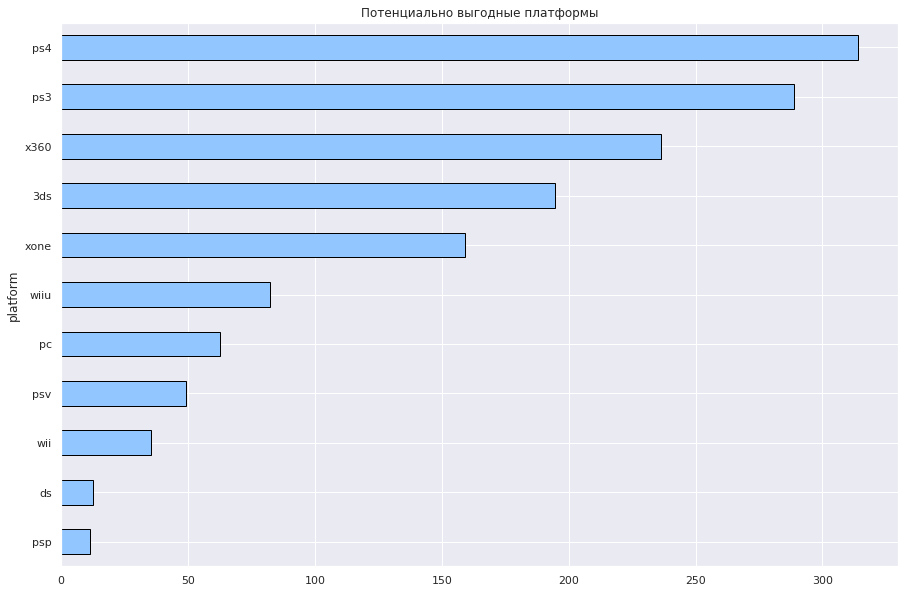

In [65]:
create_any_bar(df, 'Потенциально выгодные платформы', 'platform', 'sum', 'sum_sales')

Over the past five years, PS4 games, the heir to the all-time favorite, the PS2, have been the biggest sellers. They are followed by PS3 games. One can judge the dominance of Sony in the gaming industry in recent years. This is followed by X360, 3DS and XOne. However, it is known that support for X360 was discontinued in early 2016, which means that I will not use games for this platform in my selection, since it cannot guarantee the highest profit. The next ranking position, WiiU, will be used instead.

For subsequent calculations, we will use data associated exclusively with these five platforms.

In [66]:
potent_benefic = df[df['platform'].isin(['ps4', 'ps3', '3ds', 'xone', 'wiiu'])] 
potent_benefic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1675 entries, 16 to 16710
Data columns (total 12 columns):
name               1675 non-null object
platform           1675 non-null object
year_of_release    1675 non-null int64
genre              1675 non-null object
na_sales           1675 non-null float64
eu_sales           1675 non-null float64
jp_sales           1675 non-null float64
other_sales        1675 non-null float64
critic_score       829 non-null float64
user_score         936 non-null float64
esrb               1675 non-null object
sum_sales          1675 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 170.1+ KB


### Box and mustache chart of global game sales by platform

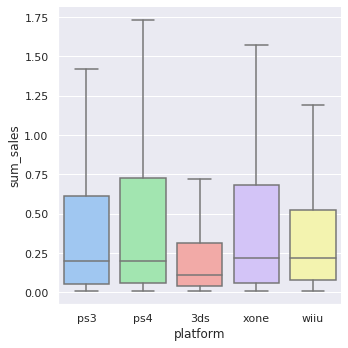

In [67]:
_ = sns.catplot(x="platform", y='sum_sales', kind="box", data=potent_benefic, orient='v', showfliers = False)

The median value of the total fees for all the best-selling platforms of the current time period is approximately equal. Only the 3DS platform is out of line and shows worse results. It is probably not possible to bet on this console.

### Scatterplot and correlation between reviews and sales

I save information about games for which information about the rating of users and critics is known.

In [68]:
df_corr = df[(df['critic_score'] > 0) & (df['user_score'] > 0)].copy() 

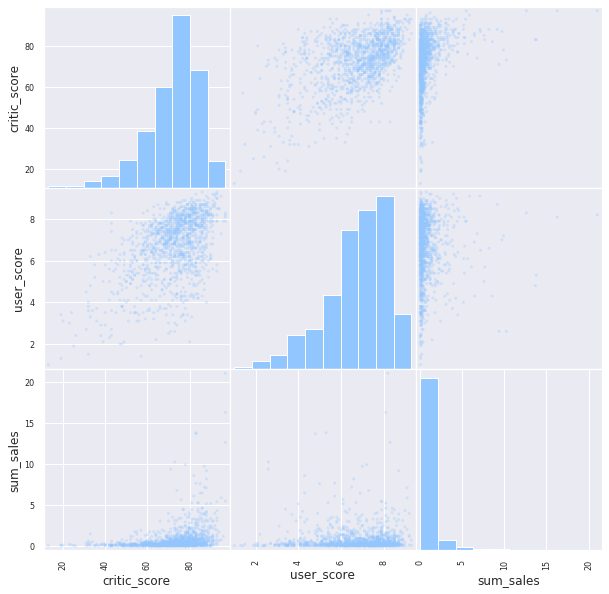

In [69]:
pd.plotting.scatter_matrix(df_corr[['critic_score', 'user_score', 'sum_sales']], alpha = 0.3, figsize = (10,10), cmap = 'GnBu')
plt.show()

Higher User Ratings and Critics Ratings show more profit. Recommended by users and critics games are expected to have more commercial success.

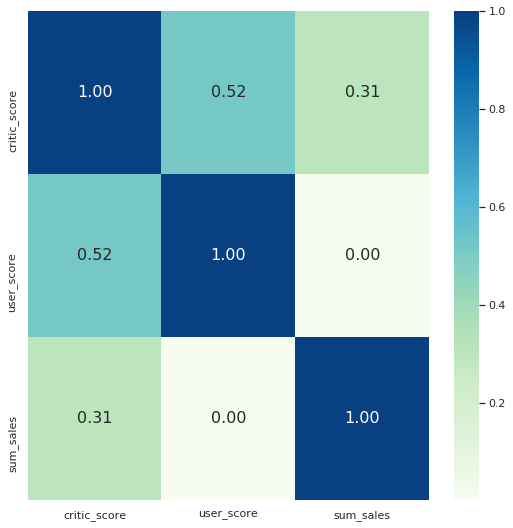

In [70]:
plt.figure(figsize=(9,9))
sns.heatmap(df_corr[['critic_score', 'user_score', 'sum_sales']].corr(), annot=True, cmap="GnBu", fmt='.2f', annot_kws={'size':16})
plt.show()

The correlation between total earnings and critical acclaim is indeed significant. But user ratings are not significant for profit. At the same time, it can be noted that user ratings are extremely dependent on critic ratings. Probably, users are guided by it when giving their rating, as well as when choosing a game.

### Ratio of withdrawals to sales of games on other platforms

Let's form a dataframe with information about all platforms, excluding the most sold ones in the current period.

In [71]:
other_platforms = df[~df['platform'].isin(['ps4', 'ps3', '3ds', 'xone', 'wiiu'])] 
#other_platforms.sample(5)

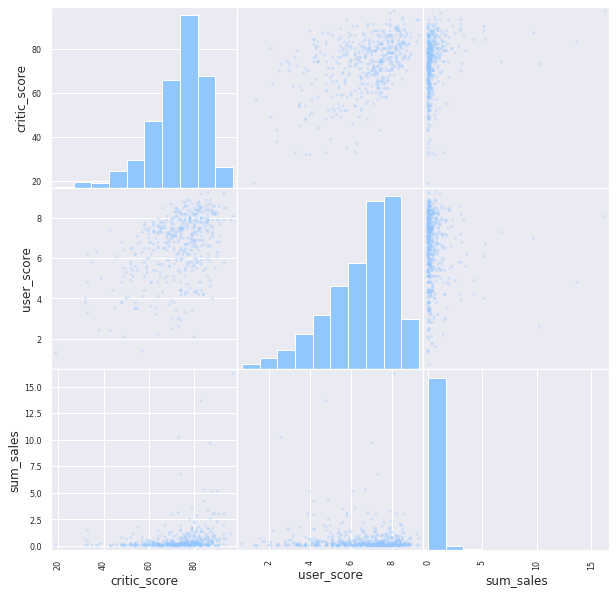

In [72]:
pd.plotting.scatter_matrix(other_platforms[['critic_score', 'user_score', 'sum_sales']], alpha = 0.3, figsize = (10,10))
plt.show()

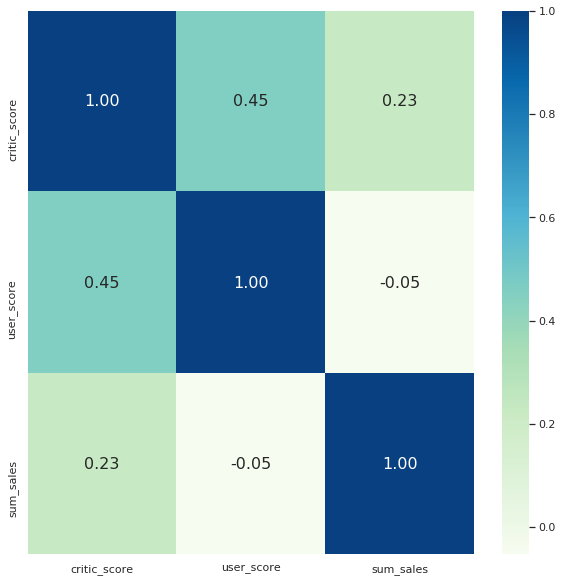

In [73]:
plt.figure(figsize=(10,10))
sns.heatmap(other_platforms[['critic_score', 'user_score', 'sum_sales']].corr(), annot=True, cmap="GnBu", fmt='.2f', annot_kws={'size':16})
plt.show()

The correlation of profit and rating scores for the top platforms and for all other market representatives are approximately equal. The conclusions were confirmed.

### General distribution of games by genre

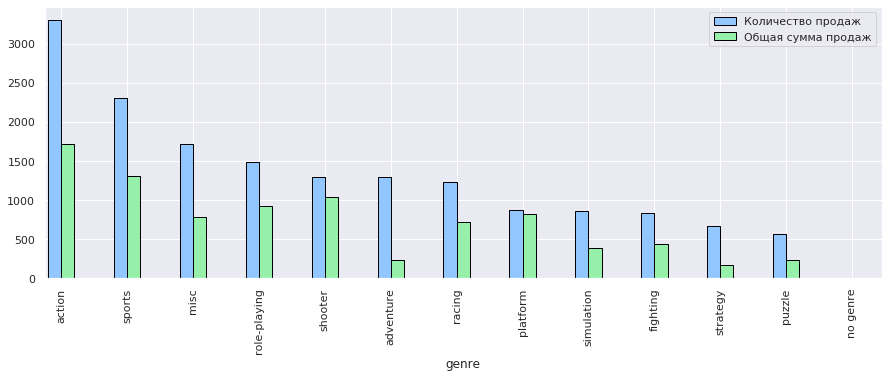

In [74]:
ax = plt.gca()

pivot = games.groupby('genre').agg({'name': 'count', 'sum_sales': 'sum'}).sort_values(by='name', ascending=False)

plot1 = pivot['name']
plot1.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, position=1)

plot2 = pivot['sum_sales']
plot2.plot(kind='bar', figsize=(15,5), ec='black', ax=ax, width=0.2, color='#97F0AA', position=0)

ax.legend(['Количество продаж', 'Общая сумма продаж'])
plt.show()

The most popular genres are Action and Sport. They lead in terms of both quantity and total sales. At the same time, the number of sales of games in the Sports genre is significantly less than Action games, and the total amount of sales differs less significantly. It can be assumed that the cost of sports games is higher. This is followed by Misc, RPG and shooter genres. The least commercially successful genres are related to intellectual activity - Strategy and Puzzle.

### Conclusion

The total release of games for different years was estimated, periodization was carried out. The platforms with the highest sales were identified, and the distribution by years was built on them. The cycle of appearance and disappearance of the platform in 10 years is determined. The current period for assessing the popularity of platforms is 5 years. The data is filtered, values ​​are left in the range of 2012-2016 of the year of release. The most potentially profitable platforms were selected and the global sales of games by platform in the current period were estimated. The influence of user ratings and critics' ratings was assessed, the correlation was calculated. The findings were confirmed on all other data. The most profitable genres of games and genres that are not popular are highlighted.

## User portrait of each region

### Function to compose the graphs

In [75]:
def top_in_regions_plot(dfr, groupby, region_sales, ax):
    pivot = dfr.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    color_dict = {'na_sales': None, 'eu_sales': 'gray', 'jp_sales': 'forestgreen'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)

### Most Popular Platforms by Region

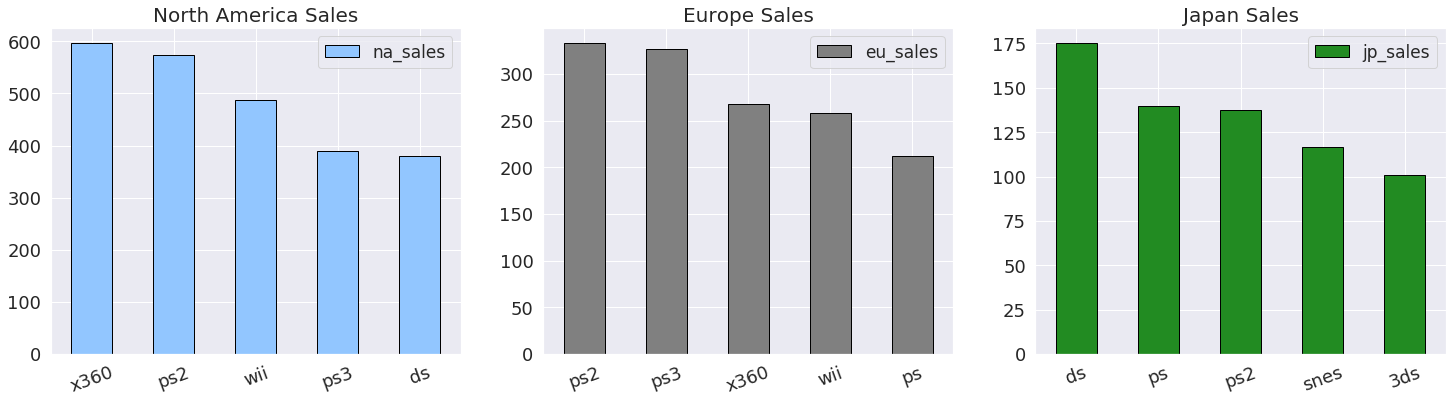

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))
top_in_regions_plot(games, 'platform', 'na_sales', 0)
top_in_regions_plot(games, 'platform', 'eu_sales', 1)
top_in_regions_plot(games, 'platform', 'jp_sales', 2)

In North America, the X360 and PS2 compete for leadership. Also popular platforms are Wii, PS3 and DS. In Europe, popularity was won by the PS series consoles. PS2 and PS3 are in the first two places, and PS is also in the top five. X360 and Wii are still in the TOP. In Japan, the situation is completely different - DS is in the lead, followed by PS and PS2, then snes and 3DS. Sony products are successful in all markets, but Microsoft can seriously compete for the championship only in North America. In Japan, Nintendo products are a big success.

### Most Popular Genres by Region

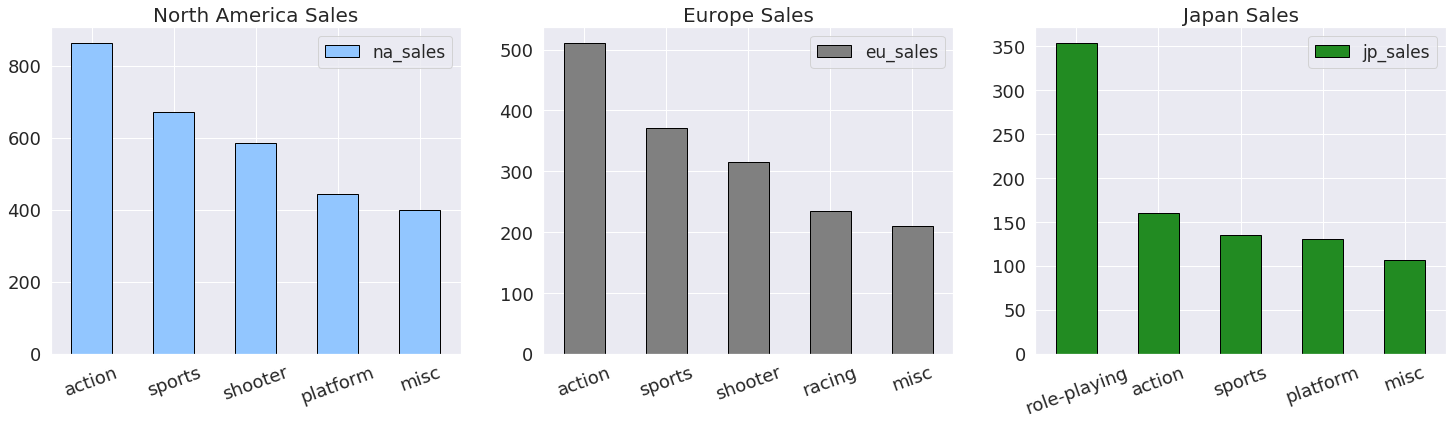

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot(games, 'genre', 'na_sales', 0)
top_in_regions_plot(games, 'genre', 'eu_sales', 1)
top_in_regions_plot(games, 'genre', 'jp_sales', 2)

The top three places in North America and Europe are occupied by the same leaders - games of the genre Action, Sports and Shooter. Action and Sports are also successful in Japan, but there is an undisputed champion - RPG.

### The impact of the ESRB rating on sales in a particular region

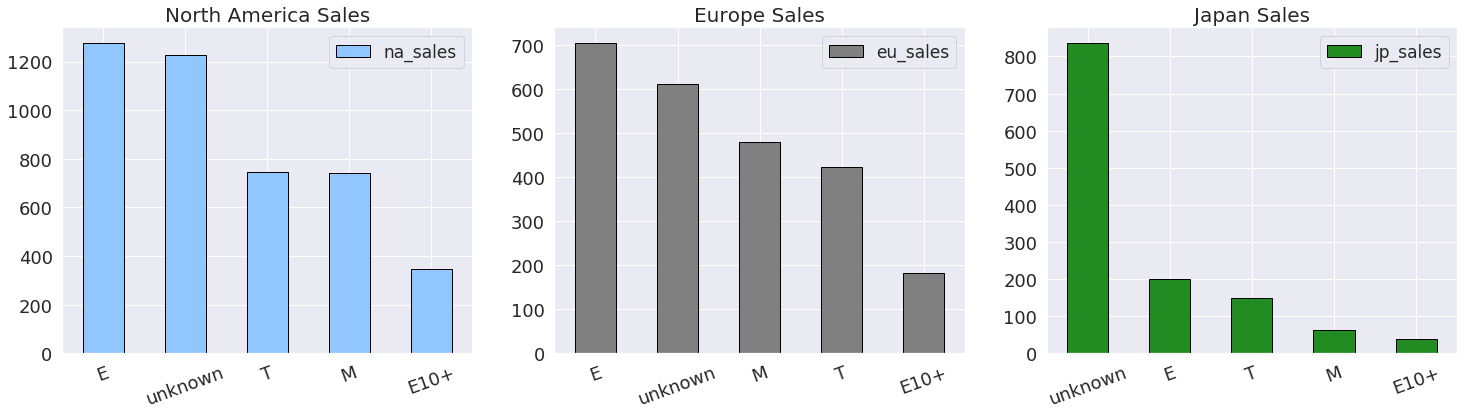

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot(games, 'esrb', 'na_sales', 0)
top_in_regions_plot(games, 'esrb', 'eu_sales', 1)
top_in_regions_plot(games, 'esrb', 'jp_sales', 2)

Unknown values have too much influence on graphs. They should be removed.

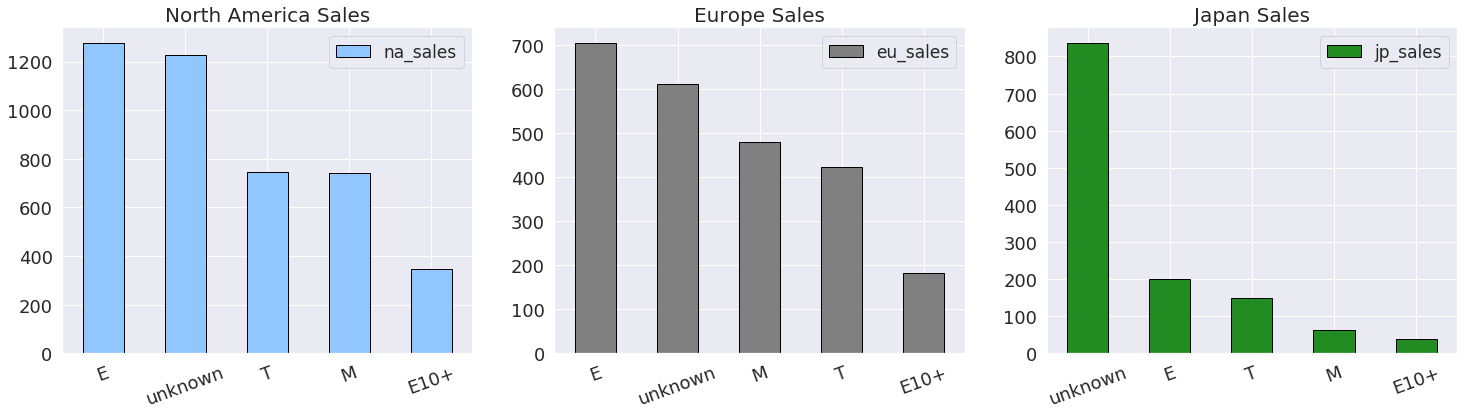

In [79]:
without_esrb = games[~games['esrb'].isin(['unknown'])] 
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_in_regions_plot(games, 'esrb', 'na_sales', 0)
top_in_regions_plot(games, 'esrb', 'eu_sales', 1)
top_in_regions_plot(games, 'esrb', 'jp_sales', 2)

«EC» («Early childhood») — «Для детей младшего возраста»
<br>
«E» («Everyone») — «Для всех» 
<br>
«T» («Teen») — «Подросткам» (от 13)
<br>
«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
<br>
«M» («Mature») — «Для взрослых» (от 17 лет)
<br>
«AO» («Adults Only 18+») — «Только для взрослых
<br>
<br>
Games without age restrictions consistently lead in all regions. Teenage games follow in Japan and North America, while adult games sell well in Europe. The situation is generally more or less the same for all regions, however, adult games are less popular in Japan.

### Conclusion

The TOP-5 most profitable platforms of the current time were compiled, the differences in sales shares were described. The TOP-5 most popular genres were identified and the impact of the ESRB rating on sales was assessed.

## Testing hypotheses

To test both hypotheses, we will use the Student's t-test (ttest_ind with equal_var=False), the samples are independent, the variance is different. The critical significance level alpha = 0.01.

### Average user ratings for Xbox One and PC platforms are the same

H0 (null hypothesis) would state that the average user ratings of the Xbox One and PC platforms are the same.
<br>
H1 (alternative hypothesis), on the contrary, will say that the average user ratings of the Xbox One and PC platforms differ from each other.

In [80]:
xbox_one = df[(df['platform'] == 'xone') & (df['user_score'] > 0)]
pc = df[(df['platform'] == 'pc') & (df['user_score'] > 0)]

In [81]:
alpha = 0.01

results = st.ttest_ind(xbox_one['user_score'], pc['user_score'], equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


We cannot judge that the average user ratings of the Xbox One and PC platforms are the same. Let's look at the distributions of these two quantities.

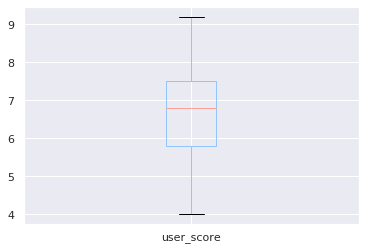

In [82]:
xbox_one.boxplot(column=['user_score'], showfliers = False)
plt.show()

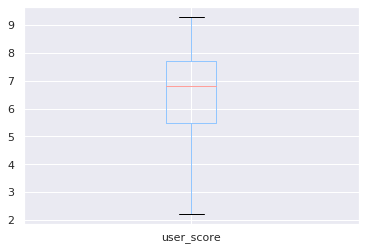

In [83]:
pc.boxplot(column=['user_score'], showfliers = False)
plt.show()

As you can see, the median score of PC users is slightly higher.

### Average user ratings for Action and Sports are different

H0 (null hypothesis) would state that the average user ratings of the Action and Sports genres are the same.
<br>H1 (alternative hypothesis), on the contrary, will say that the average user ratings of Action and Sports genres differ from each other.

In [84]:
action = df[(df['genre'] == 'action') & (df['user_score'] > 0)]
sports = df[(df['genre'] == 'sports') & (df['user_score'] > 0)]

In [85]:
alpha = 0.01

results = st.ttest_ind(action['user_score'], sports['user_score'], equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Great, chances are that the average user rating for the Action and Sports genres is the same. Let's refine the data by looking at their distribution.

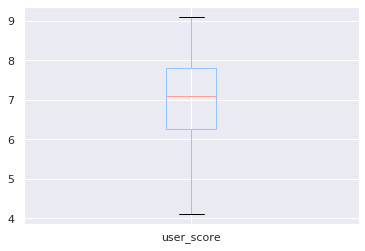

In [86]:
action.boxplot(column=['user_score'], showfliers = False)
plt.show()

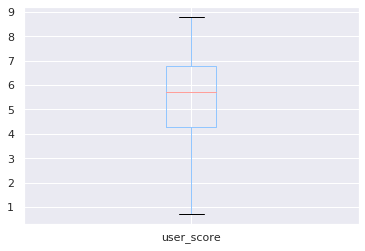

In [87]:
sports.boxplot(column=['user_score'], showfliers = False)
plt.show()

Yes, the medians look the same.

## General Conclusion

Based on information received up to 2016 and updated for the current period, investments in games for PS4 and PS3, as well as Xbox One and 3DS, seem to be the most promising.
<br>The most popular and profitable games will be Action and Sports games, as well as RPG for Japan. Ideally, this should be a game with an age limit of E.
<br>A game's profitability is significantly affected by critics' ratings, but the user rating has no such influence, moreover, it is largely determined by critics' reviews.
<br>Average user ratings for Xbox One and PC games are different, with a margin in favor of PC.
<br>Average user ratings for Action and Sports games are probably the same.